#### Introduction
The data collected only represents a sample of the total population for each species.
For this reason bootstrapping is required. 
Bootstrapping can estimate the central tendency and variability of a population.

#### Bootstrapping and GAM stage 2 Workflow
1) The dataset is filtered using the species code.
2) The data for each species is randomly sampled with replacement, until the original 
sample size is reached.
3) The hyperparameters are selected using the optimal criterion determined during the stage 2 gam 
validation (BIC, lambda, spline count).
4) The model is used to predict relative abundance for each of the study years (1993-2023)
5) Predictions for each year and each resample are stored.
6) The number of loops is set to 500. This means there will be 500 relative 
abundance ratios for each year.

#### Computing Long Term Trends
1) The results are grouped by year.
2) The median of the index ratios is computed. 
3) 95% confidence intervals are established for each year by using np.quantile().
4) The upper, lower and median log index ratios are back transformed using np.exp().
5) Upper, lower and median values are plotted on a linegraph with year on the x-axis.

#### Computing Annual Abundance Ratios
The annual abundance ratios are the geometric means of the yearly index ratios.
They will be overlayed on the same linegraph as the long term trends for comparison.
1) log index ratios from the original dataset ('species_data') are grouped by year. 
2) Geometric means are computed by taking the arithmetic mean of the log index ratios.
3) The geometric means are back-transformed using np.exp().

In [2]:
# First the packages are imported
import pandas as pd
import numpy as np
from pygam import LinearGAM, s
import os
from pathlib import Path

# Importing localised file directory
project_root = Path(os.environ['butterfly_project'])

# The data is imported. 
# 'ukbms' contains the explanatory data that will be used in the GAM. 
ukbms = pd.read_csv(project_root/'Data'/'UKBMS'/'gam_2'/'ukbms_species_analysis.csv', index_col=0)

# 'master_dataset' contains the common names for each butterfly. 
# These will be useful when presenting the results.
master_dataset = pd.read_csv(project_root/'Data'/'UKBMS'/'ukbms_master_v1.csv', index_col=0)

In [3]:
# First, 'master_dataset' is filtered by row and column to remove redundant information.
# 'species_code' is used as the primary key for accessing 'common names'.
common_name = (
    master_dataset[['species_code','common_name']]
    .drop_duplicates()
    .reset_index(drop=True)
)

In [4]:
# The minimum number of records required for analysis is 500. 
# Species with a record count below this threshold are removed.

# Species are grouped by 'species_code' and a count is applied in a new column.
ukbms['record_count'] = (
    ukbms.groupby('species_code')['species_code']
    .transform('count')
)

# Rows are only retained if the count is at least 500.
ukbms = ukbms[ukbms['record_count']>=500].reset_index(drop=True)

# After filtering, the count column is removed. 
ukbms = ukbms.drop(columns=['record_count'])

#### Selecting a species subset

In [5]:
species_data = (
    ukbms[ukbms['species_code']==54] # Enter species code to be analysed here
    .reset_index(drop=True) 
)

#### Defining the Hyperparameters

In [ ]:
splines = np.arange(4,6,1)
lam = np.logspace(-3,3,30)

# product() becomes 'exhausted' after 1 iteration. 
# However, to apply BIC, parameter combinations need to be looped. 
# For this reason each combination needs to be stored in a list.
from itertools import product
combinations = list(product(lam, splines))

In [ ]:
# Specifying study range in years
# Note 'study years' denotes the period to be evaluated during the final analysis.
# This is different to the data that will be input into the model.
study_years = np.arange(1993, 2024, 1)

#### Creating the Model
Two loops are created here:
- The inner loop is used for the GAM. Predictions are generated for all the combinations of hyperparameters.
- The outer loop is used to bootstrap species data (which is then fed into the inner loop).

In [7]:
# Creating lists and dataframes for the 'outer loop'. These will store model results. 
boot_results = pd.DataFrame() # Bootstrap results will be stored in this dataframe.
np.random.seed(40) # For reproducibility, the random seed is set to 40. 
for i in range(500): # The GAM will be looped 500 times.
    # 'sample_n' distinguishes boot iterations (0<=i<=499). 
    # For each run there are 31 predictions.
    sample_n = [i]*31 
    predictions = [] # Index ratios will be stored in this list
    # Creating X and y data. replace=True samples with replacement.
    boot_data = species_data.sample(frac=1, replace=True) 
    X = boot_data[['year']].to_numpy() # X must be a 2D array.
    y = boot_data['log_index_ratio'] # y can be a pandas series.
    opt_bic = [] # The BIC score generated by each model is listed
    opt_lam = [] # The lambda value for each model is listed
    opt_spline = [] # The spline count for each model is listed

    # Running the GAM in the 'inner loop'.
    # Here optimal parameters are fitted to the bootstrapped data.
    for lam, splines in combinations: # 'Loops through' each parameter combination.
        model = LinearGAM(s(0), lam=lam, n_splines=splines).fit(X,y)
        opt_lam.append(model.lam[0][0]) # extracting the model lambda value
        opt_spline.append(model.n_splines[0]) # extracting the model spline count
        # Pygam does not compute BIC. Manual computation is required. 
        opt_bic.append(
            round(-2*model.statistics_['loglikelihood'] # Likelihood function of BIC
                  + np.log(len(species_data))*model.statistics_['edof'],5) # penalty 
        ) 
        
    # Inner loop is complete. Returning to the outer loop.
    # Now results must be combined and filtered in outer loop.
    # Combining parameter and BIC lists into a dataframe
    params = pd.DataFrame({'bic':opt_bic,
                           'lam':opt_lam,
                           'splines':opt_spline}) 
    min_bic = (
        params['bic']
        .min() # Identifying the minimum BIC score. This indicates the optimal model.
    )
    params_filt = (
        params[params['bic']==min_bic] # Subsetting the 'params' df using 'min_bic' 
        .iloc[0,:] # First row and all columns are extracted.
    )
    final_lam = params_filt['lam'] # Defining the input lambda for the final model
    final_spline = (
        params_filt['splines'] #  Defining the input spline count for the final model
        .astype(int) # n_splines argument does not accept float. Converting to integer. 
    )
    # Fitting the GAM with bootstrapped data and optimal parameters
    final_model = LinearGAM(s(0), lam=final_lam, n_splines=final_spline).fit(X,y)
    predictions.append( # Predictions are stored in preditions list
        final_model.predict(study_years) # Explanatory data is input into the model.
    ) 
    # storing results specific to the bootstrap iteration 
    sample_results = pd.DataFrame({'sample_n':sample_n, # records bootstrap iteration
                                   'year':study_years,
                                   'log_predict':predictions[0]}) 
    # At the end of each loop, the bootstrapped peredictions are added into the final 
    # 'boot_results' dataframe which was defined at the beginning of the outer loop.
    boot_results = pd.concat([boot_results, sample_results], ignore_index=True) 

#### long term trends
Computing the median log index ratio for every year:

In [ ]:
boot_results['median_log_predict'] = (
    boot_results.groupby('year')['log_predict'] # predictions are grouped by year
    .transform('median')
)

The upper boundary (97.5th percentile) is computed for each year:

In [9]:
boot_results['upper_b_log_predict'] = (
    boot_results.groupby('year')['log_predict'] # predictions are grouped by year
    .transform(lambda x: np.quantile(x, 0.975))
)

The lower boundary (2.5th percentile) is computed for each year:

In [10]:
boot_results['lower_b_log_predict'] = (
    boot_results.groupby('year')['log_predict'] # predictions are grouped by year
    .transform(lambda x: np.quantile(x, 0.025))
)

In [11]:
# The bootstrap predictions are no longer needed. 
# Rows with duplicate years removed, leaving 1 row for each year.
boot_stats_log = (
    boot_results.drop_duplicates('year')
    .drop(columns=['sample_n','log_predict']) # redundant columns. 
    .reset_index(drop=True) # Index is reset due to row removal. 
)

Back transformation of the median, upper and lower boundary log index ratios:

In [12]:
# The log index ratios are back-transformed using np.exp()
boot_stats = boot_stats_log.copy()

boot_stats = boot_stats_log[['median_log_predict',
                             'upper_b_log_predict',
                             'lower_b_log_predict']].transform(lambda x: np.exp(x))

# Values are no longer in log form. Columns are renamed to reflect this.
boot_stats = boot_stats.rename(columns={'median_log_predict':'median_predict',
                                        'upper_b_log_predict':'upper_b_predict',
                                        'lower_b_log_predict':'lower_b_predict'})

# 'year' column is copied from boot_stats_log and added to 'boot_stats'
boot_stats['year'] = boot_stats_log['year']

#### Computing the annual abundance ratios
This will enable long term trends to be compared directly with annual variation.

In [ ]:
# The original species dataset is grouped by year. 
# The arithmetic mean is computed in log form before back-transformation.
geometric_mean = (species_data
                  .groupby('year')['log_index_ratio']
                  .agg(lambda x: np.exp(x.mean())) # mean is applied to year grouping
                  .reset_index() # year is reinstated as column
                 )

# The model uses data from 1988, although study period starts in 1993
# Hence, the data is filtered to years greater than or equal to 1993.
geometric_mean = (
    geometric_mean[geometric_mean['year']>=1993]
    .reset_index(drop=True)
    .iloc[:,1] # geometric mean is stored in 2nd column 
)

In [14]:
# The gemotric mean for each year is added to the 'boot_stats' dataframe
boot_stats['geometric_mean'] = geometric_mean

In [15]:
# The 'boot_results' dataframe is saved in csv format for future analysis
boot_results.to_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_results_54.csv')
# The 'boot_stats' dataframe is saved in csv format for future analysis
boot_stats.to_csv(project_root/'Data'/'UKBMS'/'bootstrap'/'boot_stats_54.csv')

#### Visualising long term trends and the annual abundance index

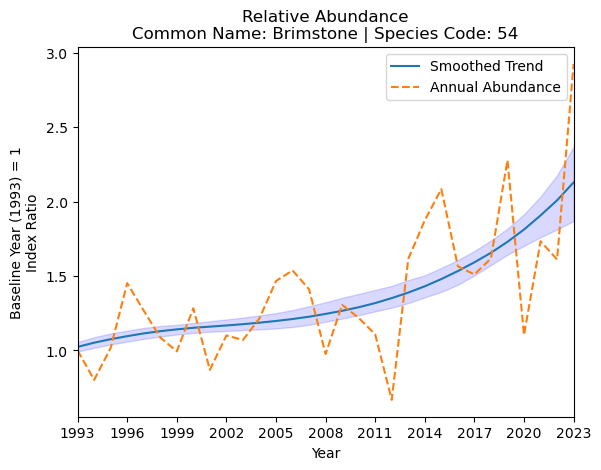

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.clf()

# The median GAM-generated prediction for each year
sns.lineplot(data=boot_stats,
             x='year',
            y='median_predict',
            label='Smoothed Trend')

# The annual abundance indices for each year
sns.lineplot(data=boot_stats,
            x='year',
            y='geometric_mean',
            linestyle='--',
            label='Annual Abundance')

# 'fill_between' shades the area between the upper and lower boundaries. 
# This represents the 95% confidence interval
plt.fill_between(data=boot_stats,
                 x='year',
                 y1='upper_b_predict',
                 y2='lower_b_predict',
                 alpha=0.15,
                 color='blue')

# The species code and species name will need to be detailed in the title.
# The species name is extracted from the 'common_name' df by using the species code 
# as the primary key.

# First the species code is extracted. Species code is in 3rd column of 'species_data'.
# All rows contain the same species code, so only the first is extracted.
species_code = species_data.iloc[0,2] 

plt.title(
    'Relative Abundance\n' + 'Common Name: ' 
    + str(common_name[common_name['species_code']==species_code] # primary key filter
          .reset_index(drop=True) # sets index of single row df to zero
          # The name is extracted from single row df by subsetting columns
          .loc[0,'common_name'])
    .capitalize() # Capitalizes every first letter
    + ' | Species Code: ' + str(species_code) # extracting species code
)

plt.legend() # displays the labels detailed in seaborn functions
plt.xlabel('Year')
plt.ylabel('Baseline Year (1993) = 1\nIndex Ratio')
plt.xticks(np.arange(1993,2024,3))
plt.margins(x=0) # Removes 'margin' around the plot area
plt.show()